In [7]:
##          DATA SHAPE DEFINITION           ##
import os, json, warnings
warnings.filterwarnings("ignore")

# Define the parameters for the data shape
videos_per_handsign = 72  # Adjust if necessary
frames_per_video = 8
num_landmarks = 51
num_coordinates = 3

num_additional_samples = 2      #how many different samples of frames_per_video frames will be taken from each video (carefull to not add too many if vids are short)

data_augmentation = True        #Add noise and transformation to generate, from each video extracted, a num_augmented_versions number of new ones (also keep between 1-4)
num_augmented_versions = 2

# Define the root directory containing handsign folders
root_path = "NomenclatedDataset"

def get_handsign_folders(root_path):
    handsign_names = {}
    handsign_video_counts = {}  # To store the video count for each handsign
    handsign_count = 0
    
    # Walk through the root directory
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        
        # Ignore non-directories
        if not os.path.isdir(folder_path):
            continue

        # If the folder starts with "#", check its subdirectories
        if folder.startswith("#"):
            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.isdir(subfolder_path):
                    handsign_names[handsign_count] = subfolder
                    # Count videos in the subfolder
                    videos = [f for f in os.listdir(subfolder_path) if f.endswith(('.mp4', '.avi', '.MOV'))]
                    handsign_video_counts[subfolder] = len(videos)
                    handsign_count += 1
        else:
            # Directly add the folder as a handsign
            handsign_names[handsign_count] = folder
            # Count videos in the folder
            videos = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.MOV'))]
            handsign_video_counts[folder] = len(videos)
            handsign_count += 1
    
    return handsign_names, handsign_video_counts

# Get the handsign names and video counts
handsign_names, handsign_video_counts = get_handsign_folders(root_path)
num_handsigns = len(handsign_names)

# Sort handsigns by the number of available videos in descending order
sorted_handsign_video_counts = dict(sorted(handsign_video_counts.items(), key=lambda item: item[1], reverse=True))

# Output the handsign names, number of handsigns, and sorted video counts
print(f"Number of handsigns: {num_handsigns}")
print("Handsign names:")
print(json.dumps(handsign_names, indent=4))

print("\nVideo counts per handsign (sorted by number of videos):")
print(json.dumps(sorted_handsign_video_counts, indent=4))


Number of handsigns: 29
Handsign names:
{
    "0": "A",
    "1": "C",
    "2": "G",
    "3": "I",
    "4": "J",
    "5": "K",
    "6": "L",
    "7": "U",
    "8": "V",
    "9": "Y",
    "10": "bien",
    "11": "buen dia",
    "12": "buenas noches",
    "13": "buenas tardes",
    "14": "chau",
    "15": "como estas",
    "16": "hola",
    "17": "mal",
    "18": "muy bien",
    "19": "nos vemos",
    "20": "apellido",
    "21": "aprender",
    "22": "argentina",
    "23": "ayuda",
    "24": "comprar",
    "25": "cumplea\u00f1os",
    "26": "hijo",
    "27": "mujer",
    "28": "sordo"
}

Video counts per handsign (sorted by number of videos):
{
    "C": 163,
    "cumplea\u00f1os": 143,
    "mujer": 137,
    "apellido": 136,
    "V": 100,
    "I": 97,
    "comprar": 84,
    "aprender": 83,
    "hijo": 83,
    "argentina": 81,
    "ayuda": 74,
    "K": 57,
    "sordo": 47,
    "A": 42,
    "G": 42,
    "J": 32,
    "L": 32,
    "U": 32,
    "Y": 31,
    "como estas": 30,
    "nos vemos": 29

In [2]:
import numpy as np

#redefine videos per handsign to accomodate for additional samples to be taken before generating the dummy array (this is done so there's no shaping/dimensions size incompatibility issue)
videos_per_handsign = videos_per_handsign * (1+num_additional_samples)

# Generate dummy data
data = [np.random.rand(videos_per_handsign, frames_per_video, num_landmarks, num_coordinates) for _ in range(num_handsigns)]

# Convert the list to a numpy array with shape (num_handsigns, videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)
data_array = np.array(data)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)

In [2]:
##          PROCESS VIDEO DATASET FUNC DEFINITIONS         ##
import cv2
import mediapipe as mp
import numpy as np
import os
from tqdm import tqdm

def extract_landmarks(hands_results, pose_results, last_handedness):
    landmarks = []

    try:
        nose_landmark = pose_results.pose_landmarks.landmark[0]
    except:
        class nose_landmark:
            x = 0
            y = 0
            z = 0
        nose_landmark = nose_landmark()

    left_hand_landmarks = [(0, 0, 0)] * 21
    right_hand_landmarks = [(0, 0, 0)] * 21

    if hands_results.multi_hand_landmarks and hands_results.multi_handedness:
        for i, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
            label = hands_results.multi_handedness[i].classification[0].label
            if label == 'Left':
                left_hand_landmarks = [(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) for lm in hand_landmarks.landmark]
                last_handedness['Left'] = True
            elif label == 'Right':
                right_hand_landmarks = [(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) for lm in hand_landmarks.landmark]
                last_handedness['Right'] = True

    if not hands_results.multi_hand_landmarks or len(hands_results.multi_hand_landmarks) < 2:
        if not last_handedness.get('Left'):
            left_hand_landmarks = [(0, 0, 0)] * 21
        if not last_handedness.get('Right'):
            right_hand_landmarks = [(0, 0, 0)] * 21

    landmarks.extend(left_hand_landmarks)
    landmarks.extend(right_hand_landmarks)

    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]
    if pose_results.pose_landmarks:
        for idx in selected_body_landmarks:
            lm = pose_results.pose_landmarks.landmark[idx]
            landmarks.append((lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z))
    else:
        landmarks.extend([(0, 0, 0)] * 9)

    return np.array(landmarks), last_handedness


def process_frame(frame, hands, pose, last_handedness):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    hands_results = hands.process(image)
    pose_results = pose.process(image)

    landmarks, last_handedness = extract_landmarks(hands_results, pose_results, last_handedness)

    return landmarks, last_handedness


def process_video_with_samples(video_path, frames_per_video, num_landmarks, num_coordinates, num_additional_samples=0):
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}.")
        return np.zeros((1 + num_additional_samples, frames_per_video, num_landmarks, num_coordinates))
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Handle case where the video contains zero frames
    if total_frames == 0:
        print(f"Warning: Video {video_path} contains zero frames. Filling this video's samples with zeros.")
        return np.zeros((1 + num_additional_samples, frames_per_video, num_landmarks, num_coordinates))
    
    # Select evenly spaced frames
    indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
    if total_frames < frames_per_video:
        print(f"Warning: Video {video_path} has fewer frames ({total_frames}) than required ({frames_per_video}). Duplicating frames to match.")

    # Initialize frame sets and track used frames
    frame_sets = [indices]
    used_frames = set(indices)
    
    # Create additional samples
    for i in range(1, num_additional_samples + 1):
        available_frames = list(set(range(total_frames)) - used_frames)

        if len(available_frames) >= frames_per_video:
            # Select from available frames without duplication
            additional_indices = np.linspace(0, len(available_frames) - 1, frames_per_video, dtype=int)
            additional_indices = [available_frames[idx] for idx in additional_indices]
        else:
            print(f"Warning: Not enough unique frames left for additional sample {i}. Duplicating frames.")
            additional_indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
        
        used_frames.update(additional_indices)
        frame_sets.append(additional_indices)

    frames_data = []
    last_handedness = {'Left': False, 'Right': False}
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    # Initialize the MediaPipe solutions
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands, \
         mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

        frame_count = 0
        frame_buffer = {}

        # Read and store all frames once
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_buffer[frame_count] = frame  # Buffer the frame for later processing
            frame_count += 1

        # Process the buffered frames for each sample set
        for frame_set in frame_sets:
            for frame_idx in frame_set:
                if frame_idx in frame_buffer:
                    landmarks, last_handedness = process_frame(frame_buffer[frame_idx], hands, pose, last_handedness)
                    frames_data.append(landmarks)
    
    cap.release()

    # Ensure the correct number of frames is collected, padding if necessary
    required_frames = frames_per_video * (1 + num_additional_samples)
    if len(frames_data) < required_frames:
        if len(frames_data) > 0:
            # Duplicate the last valid frame to fill the gap
            frames_data.extend([frames_data[-1]] * (required_frames - len(frames_data)))
        else:
            # Fill with zeros if no frames were processed
            frames_data.extend([np.zeros((num_landmarks, num_coordinates))] * required_frames)

    # Reshape the data into the expected format
    reshaped_data = np.array(frames_data).reshape((1 + num_additional_samples, frames_per_video, num_landmarks, num_coordinates))
    
    return reshaped_data


def process_dataset_with_samples(root_path, handsign_names, frames_per_video, num_landmarks, num_coordinates, videos_per_handsign, num_additional_samples=0):
    data = []

    for handsign_index in tqdm(range(len(handsign_names)), desc="Processing handsigns"):
        handsign_folder = handsign_names[handsign_index]
        handsign_path = os.path.join(root_path, handsign_folder)
        
        if not os.path.exists(handsign_path):
            print(f"Warning: Directory {handsign_path} does not exist. Skipping.")
            data.append(np.zeros((videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)))
            continue

        videos = [f for f in os.listdir(handsign_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        handsign_data = []

        # Calculate how many videos to process based on videos_per_handsign and num_additional_samples
        max_videos_to_process = videos_per_handsign // (1 + num_additional_samples)
        
        # Process the required number of videos
        for video in tqdm(videos[:max_videos_to_process], desc=f"Processing videos for handsign {handsign_index}", leave=False):
            video_path = os.path.join(handsign_path, video)
            
            # Call the updated process_video_with_samples function
            video_data = process_video_with_samples(video_path, frames_per_video, num_landmarks, num_coordinates, num_additional_samples)
            
            # Append all generated samples (original + additional) from the video
            for sample in video_data:
                handsign_data.append(sample)

        handsign_data = np.array(handsign_data)
        total_video_samples = handsign_data.shape[0]  # Total samples generated from the videos processed

        # Ensure total number of video samples matches the predefined videos_per_handsign
        if total_video_samples < videos_per_handsign:
            padding_needed = videos_per_handsign - total_video_samples
            print(f"Warning: Handsign {handsign_index} ('{handsign_folder}') has only {total_video_samples} samples. "
                  f"Padding with {padding_needed} empty samples.")
            handsign_data = np.pad(handsign_data, ((0, padding_needed), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif total_video_samples > videos_per_handsign:
            handsign_data = handsign_data[:videos_per_handsign]
            print(f"Warning: More samples generated ({total_video_samples}) than expected ({videos_per_handsign}). Trimming excess samples.")

        data.append(handsign_data)

    final_data = np.array(data)
    print(f"Final dataset shape: {final_data.shape}")

    return final_data




In [ ]:
##          PROCESS VIDEOS DATASET FUNC CALLING         ##
data_array = process_dataset_with_samples(root_path, handsign_names, frames_per_video, num_landmarks, num_coordinates, videos_per_handsign, num_additional_samples)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)
print("Data saved to handsigns_data.npy")
    

In [5]:
##        DATA AUGMENTATION (OPTIONAL)        ##

def apply_rotation(landmarks, angle_degrees_x, angle_degrees_y, angle_degrees_z):
    """Rotate the landmarks in 3D space by given angles around X, Y, and Z axes."""
    angle_radians_x = np.radians(angle_degrees_x)
    angle_radians_y = np.radians(angle_degrees_y)
    angle_radians_z = np.radians(angle_degrees_z)

    # Rotation matrix around the X-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(angle_radians_x), -np.sin(angle_radians_x)],
        [0, np.sin(angle_radians_x), np.cos(angle_radians_x)]
    ])

    # Rotation matrix around the Y-axis
    rotation_matrix_y = np.array([
        [np.cos(angle_radians_y), 0, np.sin(angle_radians_y)],
        [0, 1, 0],
        [-np.sin(angle_radians_y), 0, np.cos(angle_radians_y)]
    ])

    # Rotation matrix around the Z-axis
    rotation_matrix_z = np.array([
        [np.cos(angle_radians_z), -np.sin(angle_radians_z), 0],
        [np.sin(angle_radians_z), np.cos(angle_radians_z), 0],
        [0, 0, 1]
    ])

    # Combine rotations by multiplying the matrices (Z * Y * X)
    combined_rotation_matrix = np.dot(np.dot(rotation_matrix_z, rotation_matrix_y), rotation_matrix_x)

    return np.dot(landmarks, combined_rotation_matrix)

def apply_scaling(landmarks, scale_factor):
    """Scale the landmarks by a given factor."""
    return landmarks * scale_factor

def apply_translation(landmarks, translation_vector):
    """Translate the landmarks by a given vector (x, y, z)."""
    return landmarks + translation_vector

def add_noise(landmarks, noise_level=0.001):
    """Add random noise to the landmarks."""
    noise = np.random.normal(0, noise_level, landmarks.shape)
    return landmarks + noise

def augment_data(data_array, num_augmented_versions=5):
    """
    Augment the data array by applying transformations.
    Creates `num_augmented_versions` augmented copies of each handsign video.
    """
    
    # Augmentation parameters
    noise_level = 0.005  # for the add_noise() function
    translation_vector = np.random.uniform(-0.05, 0.05, 3)  # for the apply_translation() function
    scale_factor = np.random.uniform(0.6, 1.6)  # for the apply_scaling() function
    angle_degrees_x = np.random.uniform(-25, 25)  # for rotation around X-axis
    angle_degrees_y = np.random.uniform(-25, 25)  # for rotation around Y-axis
    angle_degrees_z = np.random.uniform(-25, 25)  # for rotation around Z-axis

    augmented_data = []
    for handsign_data in data_array:
        augmented_handsign_data = []
        for video_data in handsign_data:
            augmented_videos = [video_data]  # Start with the original video data

            for _ in range(num_augmented_versions):
                augmented_video = []
                for frame in video_data:
                    # Apply a combination of augmentations
                    rotated_frame = apply_rotation(frame, angle_degrees_x, angle_degrees_y, angle_degrees_z)
                    scaled_frame = apply_scaling(rotated_frame, scale_factor)
                    translated_frame = apply_translation(scaled_frame, translation_vector)
                    noisy_frame = add_noise(translated_frame, noise_level)

                    augmented_video.append(noisy_frame)
                
                augmented_videos.append(np.array(augmented_video))

            # Flatten the augmented videos for each original video
            augmented_handsign_data.extend(augmented_videos)

        augmented_data.append(np.array(augmented_handsign_data))
    
    return np.array(augmented_data)

# Load original handsigns data
handsigns_data = np.load('handsigns_data.npy')

# Apply augmentation
if data_augmentation:
    augmented_data = augment_data(handsigns_data, num_augmented_versions)
    # Save the augmented data to a new .npy file
    np.save('handsigns_data_augmented.npy', augmented_data)
    # Update the videos per handsign value to match the videos generated by the augmentation
    data_array = np.load('handsigns_data_augmented.npy')
    videos_per_handsign = data_array.shape[1]
    
    print("Augmented data saved to handsigns_data_augmented.npy, videos_per_handsign augmented by "+str(num_augmented_versions)+" per existing video for a total of "+str(videos_per_handsign)+" videos per handsign")
else:
    print("no data augmentation was performed")

Augmented data saved to handsigns_data_augmented.npy, videos_per_handsign augmented by 2 per existing video for a total of 648 videos per handsign


In [12]:
##          MODEL DEFINITION            ##
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Reshape input to (frames_per_video, num_landmarks * num_coordinates)
new_input_shape = (frames_per_video, num_landmarks * num_coordinates)

model = Sequential([
    # Reshape layer
    Reshape((frames_per_video, num_landmarks * num_coordinates), input_shape=(frames_per_video, num_landmarks, num_coordinates)),
    
    # LSTM layers with Dropout and Batch Normalization to reduce overfitting
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Fully connected layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Output layer for multi-class classification
    Dense(num_handsigns, activation='softmax')  # Softmax for multi-class classification
])

# Specify a learning rate
learning_rate = 0.0005

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary() # Uncomment if you want to see the model summary


In [13]:
##        DATA PREPROCESSING FOR TRAINING            ##
from sklearn.model_selection import train_test_split
import shutil

# Load the data from the .npy file, making a copy to use for training as to not modify the original extracted data
if data_augmentation:
    shutil.copy('handsigns_data_augmented.npy', 'handsigns_data_training_copy.npy')
    data_array = np.load('handsigns_data_training_copy.npy')
    
    # Update videos_per_handsign based on augmentation
    #videos_per_handsign = data_array.shape[1]  # Dynamically update based on the new augmented shape
    print("using handsigns_data_augmented.npy. After augmentation videos per handsign updated to: " + str(data_array.shape[1]))
else:
    shutil.copy('handsigns_data.npy', 'handsigns_data_training_copy.npy')
    data_array = np.load('handsigns_data_training_copy.npy')

print('Array used shape: ',data_array.shape)
# X remains unchanged
X = data_array 

# Create labels for each handsign (0 to num_handsigns-1)
# This creates a label for each hand sign, repeated for each video
y = np.repeat(np.arange(num_handsigns), videos_per_handsign)
y = y.reshape(num_handsigns, videos_per_handsign)

# Initialize lists to hold training and validation data
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []

# Split videos and labels for each handsign
for handsign_index in range(num_handsigns):
    # Split the videos within each handsign
    train_indices, val_indices = train_test_split(
        np.arange(videos_per_handsign), 
        test_size=0.2, 
        random_state=42
    )
    
    # Select training and validation data for this handsign
    X_train_list.append(data_array[handsign_index, train_indices])
    X_val_list.append(data_array[handsign_index, val_indices])
    
    # Select corresponding labels
    y_train_list.append(y[handsign_index, train_indices])
    y_val_list.append(y[handsign_index, val_indices])

# Concatenate lists to form the final training and validation sets
X_train = np.concatenate(X_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Reshape X_train and X_val to fit the model's expected input shape
X_train = X_train.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
X_val = X_val.reshape(-1, frames_per_video, num_landmarks, num_coordinates)

# Flatten y_train and y_val
y_train = y_train.flatten()
y_val = y_val.flatten()

using handsigns_data_augmented.npy. After augmentation videos per handsign updated to: 648
Array used shape:  (10, 648, 8, 51, 3)


Epoch 1/500
156/162 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1382 - loss: 20.3259
Epoch 1: val_loss improved from inf to 12.51744, saving model to best_handsigns_model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1400 - loss: 20.2042 - val_accuracy: 0.1869 - val_loss: 12.5174 - learning_rate: 5.0000e-04
Epoch 2/500
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3009 - loss: 11.5788
Epoch 2: val_loss improved from 12.51744 to 8.08181, saving model to best_handsigns_model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3013 - loss: 11.5578 - val_accuracy: 0.4523 - val_loss: 8.0818 - learning_rate: 5.0000e-04
Epoch 3/500
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3740 - loss: 7.8086
Epoch 3: val_loss improved from 8.08181 to 5.61952, saving model to best_handsigns_model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3744 - loss: 7.7936 - val_accuracy: 0.6008 - val_loss: 5.6195 - learning_rate: 5.0000e-04
Epoch 4/500
1

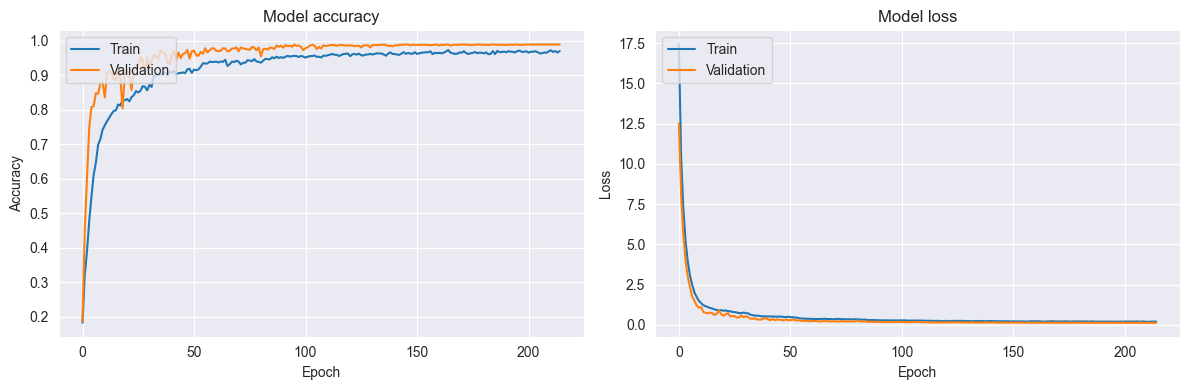

In [14]:
##          MODEL TRAINING          ##
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback helpers for model training #
# Early stopping to stop training when validation loss stops improving
# Model checkpointing to save the best model during training
# Reduce learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  
checkpoint = ModelCheckpoint('best_handsigns_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


# Save the trained model
model.save('handsigns_model.h5')

# Optionally, save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    

    
##          TRAINING HISTORY ANALYSIS           ##
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# If you want to save the plot instead of displaying it:
# plt.savefig('training_history.png')

In [ ]:
##          SINGLE VIDEO PREDICTION TEST         ##
def predict_handsign(video_path, model):
    # Process the video to extract landmarks
    video_data = process_video(video_path)
    
    # Reshape the data to match the model input shape (add batch dimension for a single video)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)
        # Make the prediction
    prediction = model.predict(video_data)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence  


if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('best_handsigns_model.keras')
    
    test_directory = "Model testing videos"
    for video_file in os.listdir(test_directory):
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(test_directory, video_file)
            predicted_class, confidence = predict_handsign(video_path, model)
            
            # Get hand sign name
            predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
            
            # Apply confidence threshold
            if confidence < 0.7:
                predicted_handsign = "Inseguro ("+predicted_handsign+")"
                
            print(f"Video: {video_file}")
            print(f"Predicted Hand Sign: {predicted_handsign}")
            print(f"Confidence: {confidence:.2f}")
            print("--------------------")


In [5]:
##          CONTINUOUS PREDICTION WITH SLIDING WINDOW           ##

import collections
import cv2
import mediapipe as mp
import numpy as np 
import tensorflow as tf
from scipy.interpolate import interp1d  # For smoothing landmarks

# Load the trained model
model = tf.keras.models.load_model('best_handsigns_model.keras')

# Initialize Mediapipe solutions outside the loop for efficiency
mp_hands = mp.solutions.hands.Hands(static_image_mode=False, 
                                    max_num_hands=2, 
                                    min_detection_confidence=0.4,  # Lowered confidence to allow for fast movement detection
                                    min_tracking_confidence=0.4)   # Lowered tracking confidence
mp_pose = mp.solutions.pose.Pose(static_image_mode=False, 
                                 min_detection_confidence=0.4, 
                                 min_tracking_confidence=0.4)

# Open webcam feed
cap = cv2.VideoCapture(0)

# Sliding window buffer for frames
frame_buffer = collections.deque(maxlen=frames_per_video)

# To smooth predictions, keep track of recent predictions
prediction_buffer = collections.deque(maxlen=3)

# Store the last prediction
last_prediction = "No Prediction"
last_confidence = 0.0

# Track missing hands to reset landmarks if missing for too long
hand_missing_threshold = 5
left_hand_missing_count = 0
right_hand_missing_count = 0

# Store the last known hand landmarks to compare in future frames
last_left_hand_landmarks = None
last_right_hand_landmarks = None

# Movement delta threshold for fast movements
movement_threshold = 0.9  # Adjusted threshold for movement delta

# Smoothing factor for missing landmarks
smoothing_factor = 0.8  # Weight to smooth landmarks during quick movements

# Draw landmarks on the frame
def draw_landmarks(frame, landmarks):
    """Draw landmarks on the frame."""
    for i, (x, y, z) in enumerate(landmarks):
        h, w, _ = frame.shape
        x = int(x * w + 325)
        y = int(y * h + 250)
        
        if i < 21:  # Left hand landmarks
            color = (0, 255, 0)
        elif i < 42:  # Right hand landmarks
            color = (0, 0, 255)
        else:  # Body landmarks
            color = (255, 0, 0)
        
        cv2.circle(frame, (x, y), 5, color, -1)

def smooth_landmarks(new_landmarks, old_landmarks):
    """Smooth landmarks by interpolating between old and new."""
    if old_landmarks is None:
        return new_landmarks

    return old_landmarks * (1 - smoothing_factor) + new_landmarks * smoothing_factor

def process_frame(frame):
    global last_left_hand_landmarks, last_right_hand_landmarks
    global left_hand_missing_count, right_hand_missing_count

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hands_results = mp_hands.process(image)
    pose_results = mp_pose.process(image)

    # Initialize a zero-filled array for landmarks (51 landmarks, each with x, y, z)
    landmarks = np.zeros((num_landmarks, num_coordinates))

    # Detect nose for relative normalization
    try:
        nose_landmark = pose_results.pose_landmarks.landmark[0]
    except:
        class nose_landmark:
            x = 0
            y = 0
            z = 0
        nose_landmark = nose_landmark()

    if hands_results.multi_hand_landmarks:
        handedness_labels = [hand.classification[0].label for hand in hands_results.multi_handedness]

        for i, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
            if handedness_labels[i] == 'Left':
                left_hand = np.array([(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) 
                                      for lm in hand_landmarks.landmark])

                # Smooth the transition between frames
                left_hand = smooth_landmarks(left_hand, last_left_hand_landmarks)
                
                # Update the stored landmarks for the next frame
                last_left_hand_landmarks = left_hand
                landmarks[:21] = left_hand  # Insert the left hand landmarks into the first 21 slots

            elif handedness_labels[i] == 'Right':
                right_hand = np.array([(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) 
                                       for lm in hand_landmarks.landmark])

                # Smooth the transition between frames
                right_hand = smooth_landmarks(right_hand, last_right_hand_landmarks)
                
                # Update the stored landmarks for the next frame
                last_right_hand_landmarks = right_hand
                landmarks[21:42] = right_hand  # Insert the right hand landmarks into slots 21-42

        # Reset the missing counts if hands are detected
        left_hand_missing_count = 0
        right_hand_missing_count = 0
    else:
        # Increment missing count when hands are not detected
        left_hand_missing_count += 1
        right_hand_missing_count += 1

        # Reuse last known landmarks if available and hands are missing for too long
        if last_left_hand_landmarks is not None:
            landmarks[:21] = last_left_hand_landmarks
        if last_right_hand_landmarks is not None:
            landmarks[21:42] = last_right_hand_landmarks

        # Reset landmarks if hands are missing for too long
        if left_hand_missing_count > hand_missing_threshold:
            last_left_hand_landmarks = None
        if right_hand_missing_count > hand_missing_threshold:
            last_right_hand_landmarks = None

    # Fill in body landmarks (9 selected)
    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]
    if pose_results.pose_landmarks:
        for idx, landmark_idx in enumerate(selected_body_landmarks):
            lm = pose_results.pose_landmarks.landmark[landmark_idx]
            landmarks[42 + idx] = (lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z)

    return landmarks


# Make a prediction based on the buffer
def predict_handsign(buffer):
    """Make a prediction based on a buffer of frames."""    
    video_data = np.array(buffer)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)

    # Make prediction
    prediction = model.predict(video_data, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    return predicted_class, confidence


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    # Process every frame (no skipping)
    landmarks = process_frame(frame)

    # Add the landmarks to the frame buffer
    frame_buffer.append(landmarks)

    # Draw the landmarks on the frame
    draw_landmarks(frame, landmarks)

    # Once the buffer is full, make a prediction using the sliding window
    if len(frame_buffer) == frames_per_video:
        predicted_class, confidence = predict_handsign(frame_buffer)
        predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")

        # Update the last prediction
        last_prediction = predicted_handsign
        last_confidence = confidence

        # Store prediction and confidence in the buffer for smoothing
        #print((predicted_class, confidence))
        prediction_buffer.append((predicted_class, confidence))

        # Average the last N predictions to smooth the output
        avg_pred_class = np.argmax(np.bincount([p[0] for p in prediction_buffer]))
        avg_confidence = np.mean([p[1] for p in prediction_buffer if p[0] == avg_pred_class])

        if avg_confidence > 0.8:
            last_prediction = handsign_names.get(avg_pred_class, f"HandSign_{avg_pred_class}")
            last_confidence = avg_confidence
        elif 0.45 < avg_confidence < 0.8:
            last_prediction = "deteccion insegura: "+handsign_names.get(avg_pred_class, f"HandSign_{avg_pred_class}")
            last_confidence = avg_confidence
        else:
            last_prediction = "deteccion nula"
            last_confidence = avg_confidence
            
    # Display the last prediction on the frame
    cv2.putText(frame, f"Predicted: {last_prediction} Conf: {last_confidence:.2f}", 
                (10, 30), cv2.FONT_ITALIC, 0.7, (0, 0, 0), 2)

    cv2.imshow('Hands Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [23]:
##         V2 CONTINUOUS PREDICTION WITH SLIDING WINDOW           ##
import cv2
import mediapipe as mp
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# Parameters for video feed and predictions
show_landmarks = True  # Toggle to show hand landmarks
show_connections = True  # Toggle to show landmark connections
show_prediction_text = True  # Toggle to show prediction and accuracy on screen
accuracy_threshold = 0.7  # Threshold for highlighting low accuracy
sliding_window_size = frames_per_video  # Size of the sliding window for prediction
smoothing_buffer_size = 10  # Buffer size for prediction smoothing (larger = smoother)
mediapipe_confidence = 0.5  # Confidence threshold for mediapipe detection

# Load the trained model
model = load_model('handsigns_model.h5')

# Initialize MediaPipe hands and pose solutions
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands(min_detection_confidence=mediapipe_confidence, min_tracking_confidence=mediapipe_confidence)
pose = mp_pose.Pose(min_detection_confidence=mediapipe_confidence, min_tracking_confidence=mediapipe_confidence)

# Set up sliding window and smoothing buffer
sliding_window = deque(maxlen=sliding_window_size)
smoothing_buffer = deque(maxlen=smoothing_buffer_size)

# Initialize video capture (webcam)
cap = cv2.VideoCapture(0)
last_handedness = {'Left': False, 'Right': False}

# Function to smooth predictions
def smooth_predictions(predictions):
    if len(predictions) > 0:
        return np.mean(predictions, axis=0)
    return np.zeros(num_handsigns)

# Main loop for video feed and prediction
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    #frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = cv2.flip(frame, 1)
    
    # Process frame to extract landmarks and results
    landmarks, last_handedness = process_frame(frame, hands, pose, last_handedness)
    hands_results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    pose_results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Append the landmarks to the sliding window
    sliding_window.append(landmarks)
    
    # Check if the sliding window is full
    if len(sliding_window) == sliding_window_size:
        # Prepare input for the model (reshape and normalize)
        input_data = np.array(sliding_window).reshape(1, sliding_window_size, num_landmarks, num_coordinates)
        
        # Predict the hand sign
        predictions = model.predict(input_data)
        prediction = np.argmax(predictions)
        confidence = np.max(predictions)
        
        # Add the prediction to the smoothing buffer
        smoothing_buffer.append(predictions)
        smoothed_predictions = smooth_predictions(smoothing_buffer)
        smoothed_prediction = np.argmax(smoothed_predictions)
        smoothed_confidence = np.max(smoothed_predictions)

        # Display prediction on screen if enabled
        if show_prediction_text:
            text = f"Sign: {handsign_names[smoothed_prediction]}, Accuracy: {smoothed_confidence:.2f}"
            if smoothed_confidence < accuracy_threshold:
                text += " (Low accuracy)"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Draw landmarks if enabled
    if show_landmarks and hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            if show_connections:
                mp.solutions.drawing_utils.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            else:
                mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks)

    # Show the frame
    cv2.imshow('Hand Sign Recognition', frame)

    # Break the loop with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━